In [7]:
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd
# import torch.nn as nn
import torch
# from tqdm.autonotebook import tqdm
import seaborn as sns
from IGT.environments import IGTEnv, NonStochasticBanditEnv
from IGT.train import train
# from STN_GPe.analysis import Analysis
# from STN_GPe.stngpe import STN_GPe_loop
# from STN_GPe.utils import load_yaml
# from numpy.fft import fft, ifft
# from STN_GPe.dbs import GenerateDBS
# import pickle
from collections import defaultdict

In [ ]:
# ENV params
NUM_ARMS = 3
MEAN_REWARD = np.array([10,20,40])
REW_STD = np.array([75, 20, 5])
SCALING_FACTOR = 100

# Training params
TRAILS = 100
EPOCHS = 10
BINS = 5
# LR = 1e-1 #5e-2
LR = 0.005

# METRICS
LAST_NUM_PICKS_ = 100 # last how many picks to be considered

In [9]:
var = 1
ARM_MONITOR = defaultdict(dict)
NUM_ARM_PICKS_MONITOR = defaultdict(dict)
PERCENTAGE_PICKS_MONITOR = defaultdict(dict)
AVG_PERCENTAGE_PICKS_MONITOR = defaultdict(dict)
DP_MONITOR = defaultdict(dict)
IP_MONITOR = defaultdict(dict)
REWARD_MONITOR = defaultdict(dict)

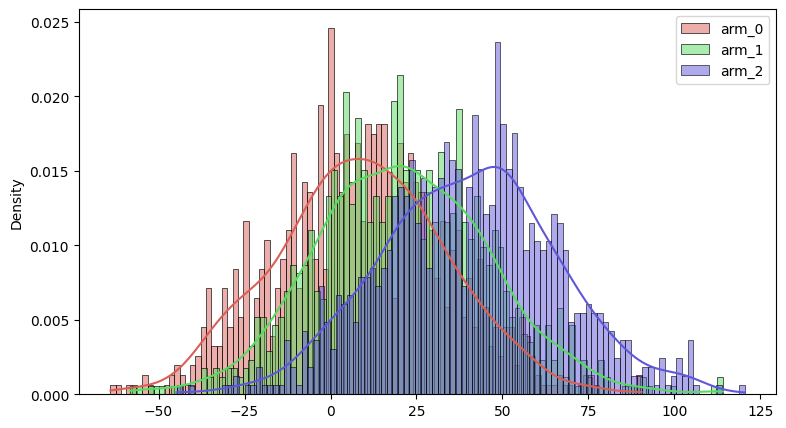

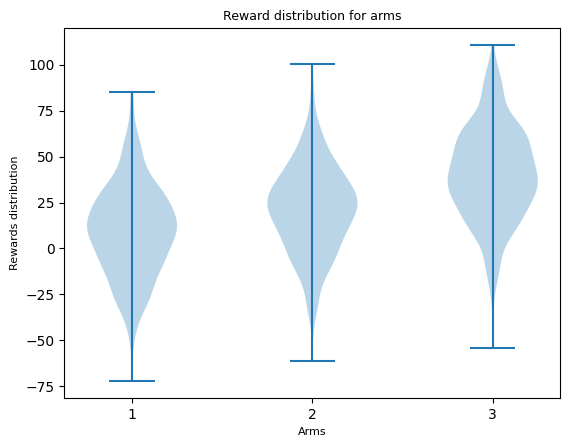

<Figure size 640x480 with 0 Axes>

In [10]:
env = NonStochasticBanditEnv(num_arms=NUM_ARMS, 
                    mean_reward=MEAN_REWARD, 
                    std = REW_STD)

env.plot_arms_reward_distribution()
env.plot_arms()

In [11]:
env = NonStochasticBanditEnv(num_arms=NUM_ARMS, 
                    mean_reward=MEAN_REWARD/SCALING_FACTOR, 
                    std = REW_STD/SCALING_FACTOR)

reward_monitor, arm_chosen_monitor, avg_counts,ip_monitor, dp_monitor, _ = train(env, 
                                                    trails = TRAILS, 
                                                    epochs = EPOCHS, 
                                                    lr = LR, 
                                                    bins = BINS,
                                                    STN_spike_output = None,
                                                    d1_amp=0.4,
                                                    d2_amp=0.3, 
                                                    gpi_threshold=0.4, 
                                                    max_gpi_iters=50,
                                                    STN_neurons=5,
                                                    stn_mean= 0.0, 
                                                    stn_std = 5,
                                                    del_lim=None, train_IP = True, 
                                                    del_med = None, printing = False,
                                                    gpi_mean= 1, gpi_var = var)

ARM_MONITOR[var] = arm_chosen_monitor
REWARD_MONITOR[var] = reward_monitor
# arms picked in last 10 trails
picks = arm_chosen_monitor[:,TRAILS-LAST_NUM_PICKS_:TRAILS]

for i in range(NUM_ARMS):
    NUM_ARM_PICKS_MONITOR[var][i] = torch.sum(picks ==i, dim = 1)
    PERCENTAGE_PICKS_MONITOR[var][i] = (NUM_ARM_PICKS_MONITOR[var][i]/LAST_NUM_PICKS_) * 100
    AVG_PERCENTAGE_PICKS_MONITOR[var][i] = torch.mean(PERCENTAGE_PICKS_MONITOR[var][i])

    DP_MONITOR[var][i] = torch.mean(dp_monitor[i], dim = 0).squeeze().detach().numpy()
    IP_MONITOR[var][i] = torch.mean(ip_monitor[i], dim = 0).squeeze().detach().numpy()
print(f'GPi variance: {var}, Percentages: {AVG_PERCENTAGE_PICKS_MONITOR[var]}')

Using Random noise
GPi variance: 1, Percentages: {0: tensor(25.7000), 1: tensor(28.7000), 2: tensor(45.6000)}


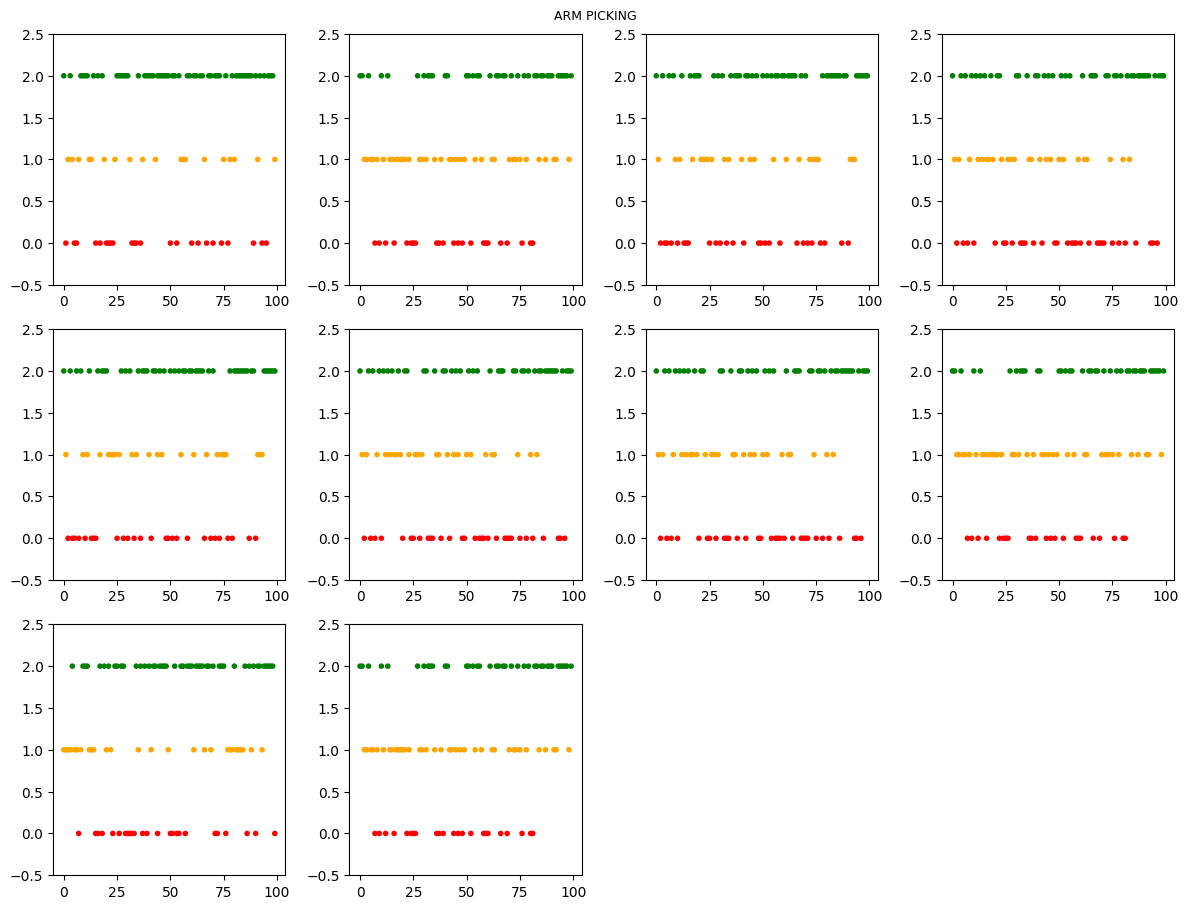

In [12]:
variance = var
color_map = {0: 'red', 1: 'orange', 2: 'green'}
plt.figure(figsize=(12,12))
plt.suptitle('ARM PICKING', fontsize = 9)
for i in range(10):
    plt.subplot(4,4,i+1)
    values = ARM_MONITOR[variance][np.random.randint(0,EPOCHS)]
    # Vectorized replacement
    color_array = np.vectorize(color_map.get)(values)
    plt.scatter(np.arange(TRAILS),values, marker = '.', color = color_array)
    plt.ylim(-0.5,2.5)
plt.tight_layout()

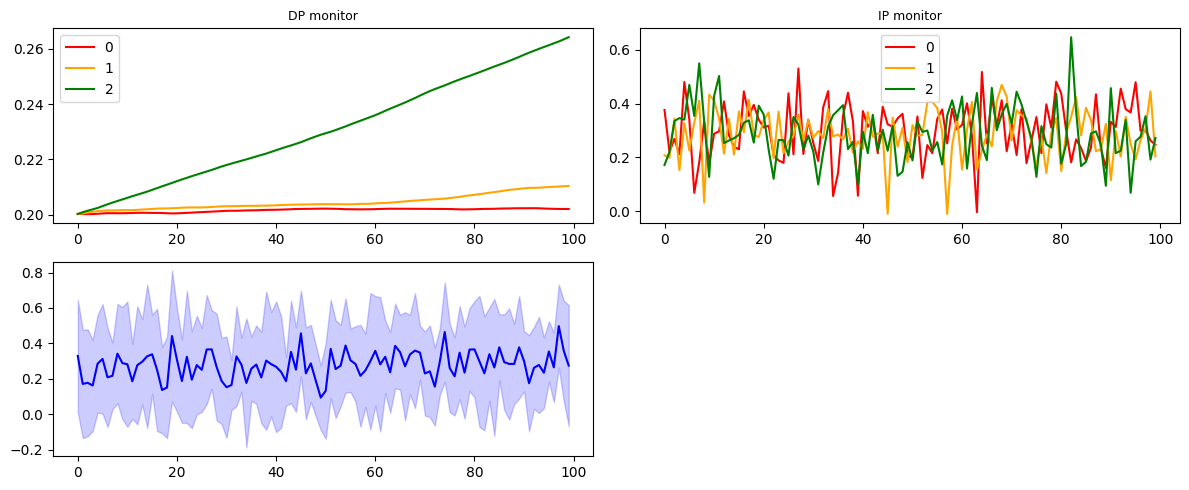

In [13]:
plt.figure(figsize = (12,5))
plt.subplot(2,2,1)
for i in range(NUM_ARMS):
    plt.plot(DP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()    
plt.title('DP monitor', fontsize = 9)
plt.subplot(2,2,2)
for i in range(NUM_ARMS):
    plt.plot(IP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()

plt.title('IP monitor', fontsize = 9)

plt.subplot(2,2,3)
mean_rew = torch.mean(REWARD_MONITOR[variance],dim =0)
std_rew = torch.std(REWARD_MONITOR[variance],dim =0)
plt.plot(np.arange(TRAILS), mean_rew, color = 'blue')
plt.fill_between(np.arange(TRAILS), y1 = mean_rew - std_rew, y2 = mean_rew + std_rew, alpha = 0.2, color = 'blue')
plt.tight_layout()

Avg variance: 0.09922402


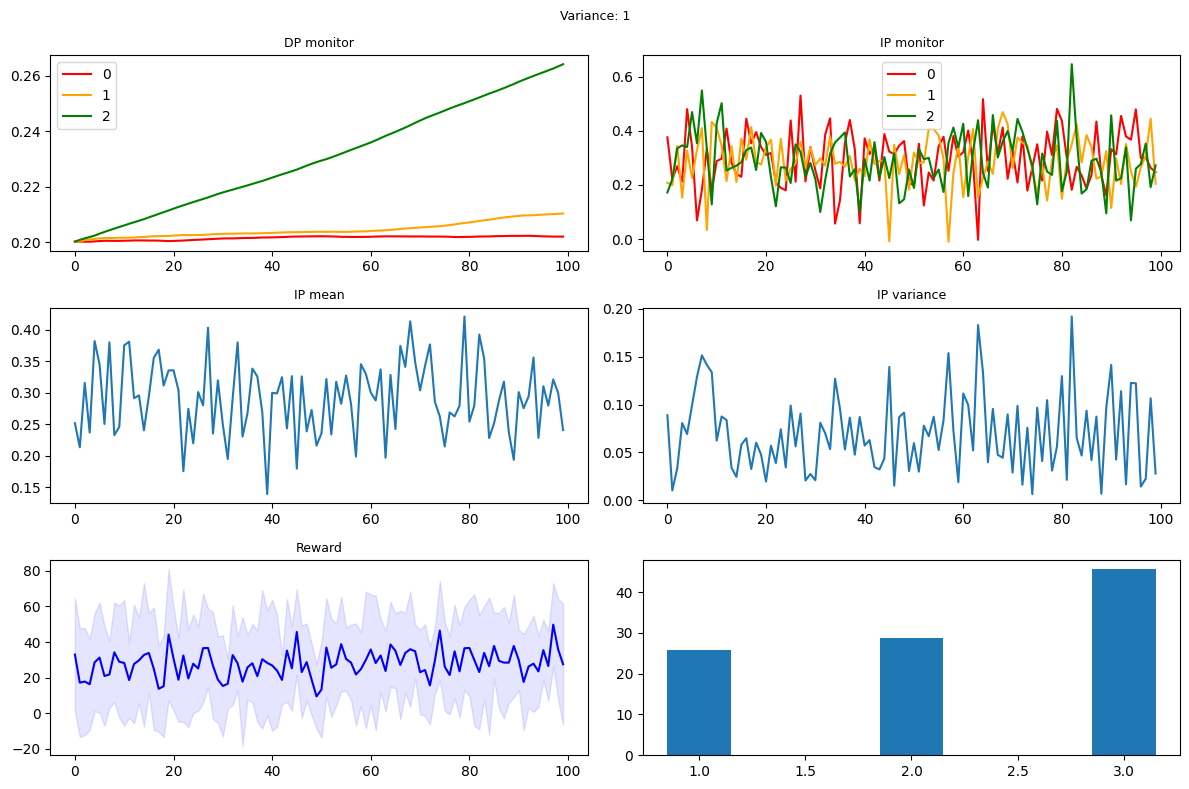

In [14]:
plt.figure(figsize = (12,8))
plt.suptitle(f'Variance: {variance}', fontsize = 9)
plt.subplot(3,2,1)
for i in range(NUM_ARMS):
    plt.plot(DP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()    
plt.title('DP monitor', fontsize = 9)
plt.subplot(3,2,2)
for i in range(NUM_ARMS):
    plt.plot(IP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()
plt.title('IP monitor', fontsize = 9)

plt.subplot(3,2,3)
plt.plot(np.mean(np.array(list(IP_MONITOR[variance].values())),0))
plt.title('IP mean', fontsize = 9)

plt.subplot(3,2,4)
plt.plot(np.std(np.array(list(IP_MONITOR[variance].values())),0))
print('Avg variance:' ,np.mean(np.std(np.array(list(IP_MONITOR[variance].values())))))
plt.title('IP variance', fontsize = 9)

plt.subplot(3,2,5)
mean_rew = torch.mean(REWARD_MONITOR[variance],dim =0) * SCALING_FACTOR
std_rew = torch.std(REWARD_MONITOR[variance],dim =0) * SCALING_FACTOR
plt.plot(np.arange(TRAILS), mean_rew, color = 'blue')
plt.fill_between(np.arange(TRAILS), y1 = mean_rew - std_rew, y2 = mean_rew + std_rew, alpha = 0.1, color = 'blue')
plt.title('Reward', fontsize = 9)
# plt.hlines(y = 10, xmin = 0, xmax = TRAILS)

plt.subplot(3,2,6)
plt.bar(np.arange(NUM_ARMS)+1,AVG_PERCENTAGE_PICKS_MONITOR[var].values(), width = 0.3)
plt.tight_layout()

